# Satellite and Data Processing Cost Estimation

In [157]:
import os
import time
import sys
sys.path.append("../Library/")

import numpy as np

from dotenv import load_dotenv
load_dotenv("../.env")

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt

import image_manipulation as ima
import deep_learning as dl
import machine_learning as ml

from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [3]:
FOLDS = 8
RESOLUTION = 1 # in meter

GIT_FOLDER = os.getenv('GIT_FOLDER')
MODELS_FOLDER = os.path.join(GIT_FOLDER, "Models")

GDRIVE_FOLDER = os.getenv('GDRIVE_FOLDER')
IMAGE_FOLDER = os.path.join(GDRIVE_FOLDER,'MFP - Satellogic/images/usgs_512_res1m/agriculture')

FNAMES = ['m_3409456_ne_15_1_20170914_x211_y654_size512_baseres1m.png',
         'm_3409456_ne_15_1_20170914_x211_y3726_size512_baseres1m.png',
         'm_3409456_ne_15_1_20170914_x211_y4238_size512_baseres1m.png',
         'm_3409456_ne_15_1_20170914_x211_y4750_size512_baseres1m.png']

# Load pretrained ResNet
We are loading the pretrained ResNet in order to calculate the last layer activations from the test images, which are then fed into the algorithm trained with 8-fold cross validation. 

In [24]:
base_model = ResNet50(weights='imagenet',
                      include_top=False)

Getting the names of the ResNet layers in order to provide the name of the last layer to the function extracting the activation.

In [25]:
activation_layers = []
for l in base_model.layers:
    l.trainable = False
    if "activation" in l.name or "relu" in l.name:
        activation_layers.append(l.name)

## Load models of fully connected neural nets trained with 8-fold CV and Resnet activations

In [6]:
models = ml.load_ensemble_models(MODELS_FOLDER, RESOLUTION, FOLDS)

# Pipeline to measure processing time

We measure the time our approach needs to entirely process 4 images, which correspond to about 1km$^2$. The steps include
* loading the images
* obtaining ResNet activations from the images
* predicting the label in an ensemble fashion using 8 models

In [71]:
start = time.time()

X = []
for fname in FNAMES:
    fullpath = os.path.join(IMAGE_FOLDER, fname)
    X.append(ima.load_image_as_rgb_array(fullpath))
    
X = np.array(X)

X_test = dl.preprocess_activations(X, base_model, activation_name = int(activation_layers[-1].split("_")[-1]))

predictions = ml.ensemble_predictions(models, X_test)

time_needed = time.time() - start
print("Time needed to process 4 images equivalent to 1km^2 of area:", round(time_needed,2), "s")

--- getting activations ---
Time needed to process 4 images equivalent to 1km^2 of area: 6.05 s


# Costs estimation

### Parameters

In [147]:
# keep this parameter fixed at 1m resolution
resolution = 1

# assuming one year of data storage
months_storage = 12

# lifespan of satellite in years
lifespan = 10

# Earth land area
earth_area_in_km2 = 148940000 # km2

def get_earth_area_in_pixels(resolution):
    earth_area_in_pixels = earth_area_in_km2/(resolution/1000)**2 # pixels
    return earth_area_in_pixels

earth_area_in_pixels = get_earth_area_in_pixels(resolution)

### Data cost

In [148]:
# Raw image processing, TODO include factor 2 compression
Gb_per_km2 = 0.005248

# cost of processing raw data to image
cost_raw_per_km2 = 0.004 # $/km2
    
# cost of downloading data from satellite
cost_download = 8 # $/Gb
cost_download_per_km2 = cost_download*Gb_per_km2

# cost of data storage
cost_storage_hot = 72e-6 # $/(km2/month)
cost_storage_cold = 36e-6 # $/(km2/month)
cost_storage_archive = 9e-6 # $/(km2/month)

cost_storage_hot_per_km2 = cost_storage_hot*months_storage
cost_storage_cold_per_km2 = cost_storage_cold*months_storage
cost_storage_archive_per_km2 = cost_storage_archive*months_storage

# cost of serving data to final client
cost_serving = 0.09 # $/Gb
cost_serving_per_km2 = cost_serving*Gb_per_km2

### Data cost for predicting human impact on image

In [149]:
time_hour_per_km2 = time_needed/3600 # hours/km2
cost_aws_per_hour = 0.4 # $/hour

cost_aws_per_km2 = cost_aws_per_hour * time_hour_per_km2 # $/km2

### Satellite cost

* Price of satellite scales cubic with resolution: launching is linear in mass, and the mass scales quadratic with mass
* A satellite of the Skysat constellation with 0.9m resolution costs about $30M 
* At 1m resolution a satellite can map 1million square km in 4.2 days (Satellogic Youtube channel)
* Assume lifespan of 10 years

In [150]:
def get_satellite_cost_per_km2(resolution):
    cost_satellite = 30e6/(resolution/0.9)**3
    map_area = 1e6/4.2*365*lifespan # km2
    cost_satellite_per_km2 = cost_satellite/map_area
    return cost_satellite_per_km2

cost_satellite_per_km2 = get_satellite_cost_per_km2(resolution)

### Total cost

In [151]:
cost_data_per_km2 = cost_raw_per_km2 + cost_download_per_km2 + cost_serving_per_km2 + \
                     cost_storage_hot_per_km2 + cost_storage_cold_per_km2 + cost_storage_archive_per_km2 + \
                     cost_aws_per_km2 + cost_satellite_per_km2

cost_total_per_km2 = cost_data_per_km2 + cost_satellite_per_km2

cost_total_per_pixel = cost_total_per_km2*1e-6

print("Total cost per square kilometer:", round(cost_total_per_km2, 4), "$")
print("Total cost per pixel:", round(cost_total_per_pixel, 10), "$")

Total cost per square kilometer: 0.0989 $
Total cost per pixel: 9.89e-08 $


### Cost to monitor the earth

In [153]:
# cost to monitor the earth
cost_monitor_earth = cost_total_per_pixel*earth_area_in_pixels

print("To monitor the entire land surface of the earth once at 1m resolution, \nthe costs amount to", 
      round(cost_monitor_earth*1e-6, 2), "M$. This assumes a satellite lifespan of", lifespan, "years.")

To monitor the entire land surface of the earth once at 1m resolution, 
the costs amount to 14.72 M$. This assumes a satellite lifespan of 10 years.


### Cost as function of resolution

In [154]:
get_monitoring_cost = lambda res: cost_monitor_earth*(1/res)**2

In [174]:
resolutions = np.linspace(0.3, 16, 500)

costs = []
for res in resolutions:
    total_costs_per_km2 = cost_data_per_km2 + get_satellite_cost_per_km2(res)
    total_costs_per_pixel = total_costs_per_km2 * 1e-6
    total_costs_earth_map = total_costs_per_pixel * get_earth_area_in_pixels(res)
    costs.append(total_costs_earth_map)

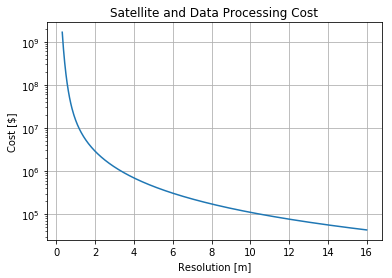

In [175]:
plt.plot(resolutions, costs)
plt.grid()

plt.title("Satellite and Data Processing Cost")
plt.yscale("log")
plt.ylabel("Cost [$]")
plt.xlabel("Resolution [m]")

plt.savefig("../report/Figures/costs.pdf")
plt.show()